# Comparative Analysis of Sentiment Analysis Techniques

In this project, we will draw comparisons between traditional statistical analysis tools and cutting-edge AI/ML models. This notebook will examine of the capabilities of SAS against models such as the BERT transformer and LSTM (Long Short-Term Memory) networks.

## Objective

The primary aim is to evaluate and contrast the effectiveness of each method in classifying sentiments expressed in a dataset composed of various tweets. This evaluation will focus on metrics such as accuracy, recall, and precision scores to evaluate each method's performance.

## Approach

1. Create "Gold Standard" testing dataset in TestDaya.ipynb.
2. Import in Tweet Sentiment Extraction train.csv data.
3. Perform Necessary pre-processing.
4. Train a Naive Bayes classifier as a baseline
5. Train a BERT Model and an LSTM Neural Network Model.
6. Test accuracy, precision, and recall on the "Gold Standard" dataset.
7. Analyze results. Explain why one model may work better than others and discuss interpretation of sarcasm and other figurative speech. 

If you are curious about the creation of the Gold Standard dataset, see the file "TestData.ipynb". I will start by importing the necessary libraries and defining necessary functions.

First, I need to import nltk to download some dependencies for lemmatization.

Next, import the packages.

In [1]:
!pip3 install xgboost
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji
import string

from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizerFast
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


/Users/oga/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/oga/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2

Now I will now read in the "Gold Standard" data and display some basic information about it.

In [2]:
data = pd.read_csv('Data/MultiClassLabeledCustomTwitterSentiments.csv', encoding='utf-8')
# Display info
print(f"Num rows: {data.shape[0]}")
data.head()

Num rows: 453


,text,target
0,I don't know about you but I think Alden Ehren...,4
1,The PR for DLPack support in CuPy has been mer...,4
2,Oh ffs. Such bs. How did he react to recent Co...,0
3,Super cool reimplementation (+ new stuff) of ...,4
4,Now targeting June 1 launch of SES-12 from Pad...,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    453 non-null    object
 1   target  453 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ KB


We have no null Values in the  data. Now let's view the distribution of the classes.

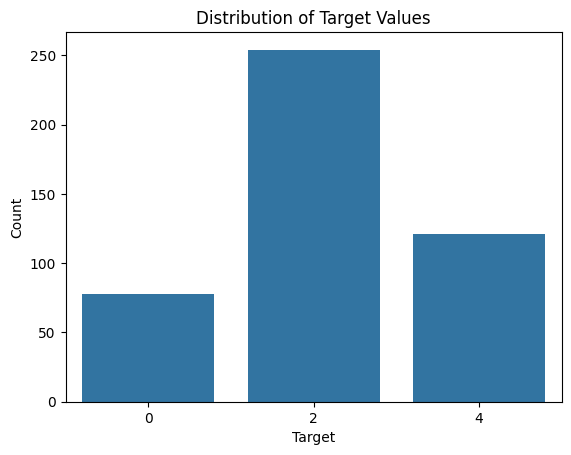

In [4]:
# Plotting the distribution 
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

TODO: quick discussion of distribution.

## Step 3

Now I will perform preprocessing of the data. Below, I have a list of functions that will be ran as a pipeline to preprocess all of the data. The first function is a function to convert all emojis to their english string equivalents. I do this since I read that including rather than removing emojis can increase accuracy. Next, I string all the characters that are not informative (punctuation, links, etc.). I then remove all hashtags from the text, and then remove all illegal characters. Lastly, I remove any back-to-back spaces.

In [5]:
# Function to replace emojis in text with their textual representations
#   Input: String representing a tweet text
#   Output: De-Emojied String
def convert_emoji(text):
    # Use the 'demojize' function from the emoji library
    return emoji.demojize(text, delimiters=("", ""))

#Remove punctuations, links, mentions
def strip_all_entities(text): 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized


def run_pipeline(text):
    texts_new = []
    for t in text:
        texts_new.append(remove_mult_spaces(
                filter_chars(
                    clean_hashtags(
                        strip_all_entities(
                            convert_emoji(t)
                        )
                    )
                )
        )
    )
    return texts_new
    

data["cleaned_text"] = run_pipeline(data.text)

Let's examine the cleaned data

In [6]:
data["cleaned_text"].head()

0    I dont know about you but I think Alden Ehrenr...
1    The PR for DLPack support in CuPy has been mer...
2    Oh ffs Such bs How did he react to recent Cons...
3    Super cool reimplementation new stuff of our d...
4    Now targeting June 1 launch of SES12 from Pad ...
Name: cleaned_text, dtype: object

Below is a visualization of how many words are in each tweet after cleaning the data. 

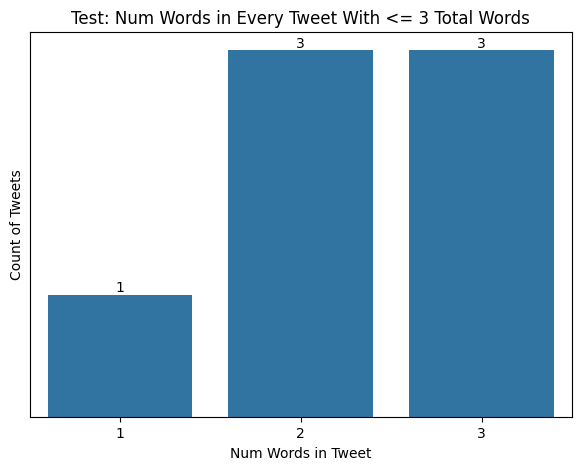

Total Rows: 7


In [7]:
text_len_threshhold = 3

text_len = []
for text in data.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

data['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<=text_len_threshhold])
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count of Tweets')
plt.xlabel('Num Words in Tweet')
plt.title(f'Test: Num Words in Every Tweet With <= {text_len_threshhold} Total Words')
plt.show()

print(f'Total Rows: {data[data["text_len"]<=text_len_threshhold].shape[0]}')


As you can see, there are no empty tweets after cleaning, and there are 1,827 total entries with 3 or less words. We will go ahead and remove all these rows to increase accuracy. 

In [8]:
print(f'Total rows before removing: {data.shape[0]}')
data = data[data["text_len"] > text_len_threshhold]
print(f'Total rows after removing: {data.shape[0]}')

Total rows before removing: 453
Total rows after removing: 446


Now, lets tokenize these cleaned tweets. This is necessary to use the BERT Model later. Below, I will tokenize all the tweets and display a distribution of the lengths of the tokenized tweets.

MAX TOKENIZED SENTENCE LENGTH: 54


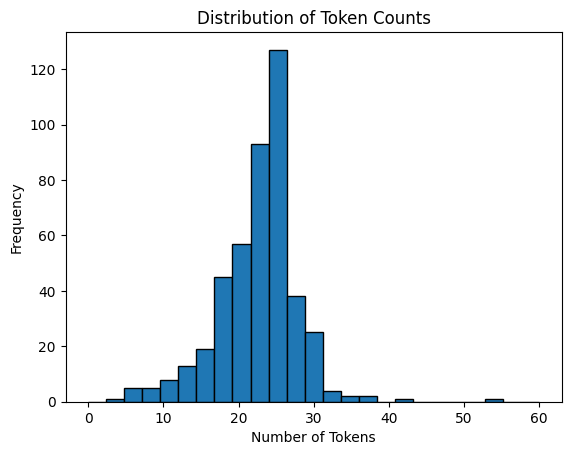

Average token count: 22.482062780269057


In [9]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def token_distribution(texts):
    # Tokenize each text and count the tokens, with tqdm for progress tracking
    token_counts = [len(tokenizer.tokenize(text)) for text in texts]

    print(f"MAX TOKENIZED SENTENCE LENGTH: {np.max(token_counts)}")
    
    # Plot the distribution of token counts up to 800
    plt.hist(token_counts, bins=25, range=(0,60), edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Counts')
    plt.show()
    
    # Calculate the average token count excluding the counts over 800
    average_token_count = sum(token_counts) / len(token_counts) if token_counts else 0
    print(f"Average token count: {average_token_count}")
    
    # Return the average token count for texts with 800 tokens or less
    return average_token_count

average_length_in_tokens = token_distribution(data['cleaned_text'].tolist())

TODO: talk about significance of token length.

Now lets look at the distribution of classes across the data.

In [10]:
data['target'].value_counts()

target
2    252
4    116
0     78
Name: count, dtype: int64

As you can see, the classes are biased towards class 2 (positive). I will use Oversampling to balance the data.

In [11]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(data['cleaned_text']).reshape(-1, 1), np.array(data['target']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['cleaned_text', 'sentiment'])
train_os['sentiment'].value_counts()

sentiment
4    252
0    252
2    252
Name: count, dtype: int64

## Step 4

Now I will train a Naive Bayes Classifier as a baseline model to compare against. The Naive Bayes is built by first tokenizing the data using CountVectorizer, then taking the tokenized data and turning them into TF-IDF scores, and then fitting on those scores.

In [12]:
X = train_os['cleaned_text'].values
y = train_os['sentiment'].values

# First split: 70% train, 30% temporary (to be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Second split: Split the 30% temporary data into 15% validation and 15% test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

encoder = preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1))
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_valid_cv = clf.transform(X_valid)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_valid_tf = tf_transformer.transform(X_valid_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)


MultinomialNB()

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(MultinomialNB(), X_train_tf, y_train_le, cv=5)
print("Cross-validated scores:", scores)

Cross-validated scores: [0.77358491 0.75471698 0.68867925 0.77358491 0.66666667]


Now let's examine the results:

In [14]:

nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['negative', 'neutral', 'positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    negative       0.73      0.97      0.83        38
     neutral       0.76      0.50      0.60        38
    positive       0.82      0.82      0.82        38

    accuracy                           0.76       114
   macro avg       0.77      0.76      0.75       114
weighted avg       0.77      0.76      0.75       114



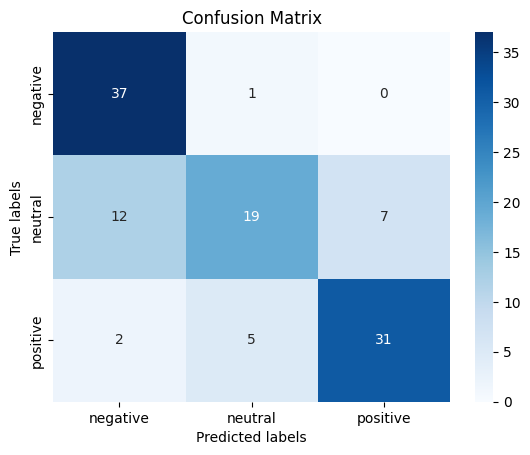

In [15]:
cm = confusion_matrix(y_test_le, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

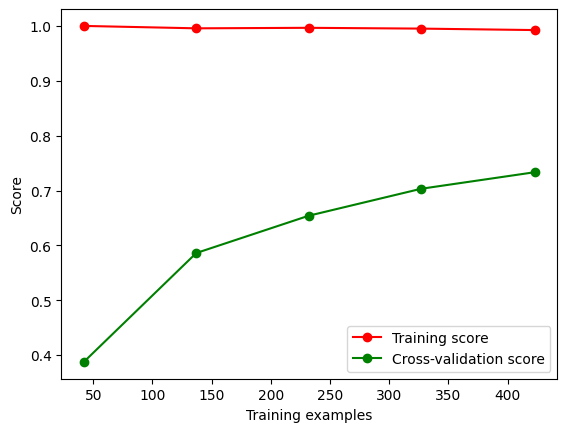

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), X_train_tf, y_train_le, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


From ChatGPT:  

1. Training Score: The training score is consistently high across the number of training examples. This indicates that the classifier is performing well on the training set.
2. Cross-Validation Score: The cross-validation score is increasing with the number of training examples, which is a good sign. It starts at a lower score with a small number of training examples but improves significantly as more data is added. It is still increasing slightly at the largest number of training examples, suggesting that it might continue to improve with even more data.
3. Gap Between Scores: There is a noticeable gap between the training and cross-validation scores. However, this gap is not widening as more training examples are added. Instead, the cross-validation score seems to be catching up with the training score, which implies the model is generalizing better as it sees more data.

/Users/oga/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


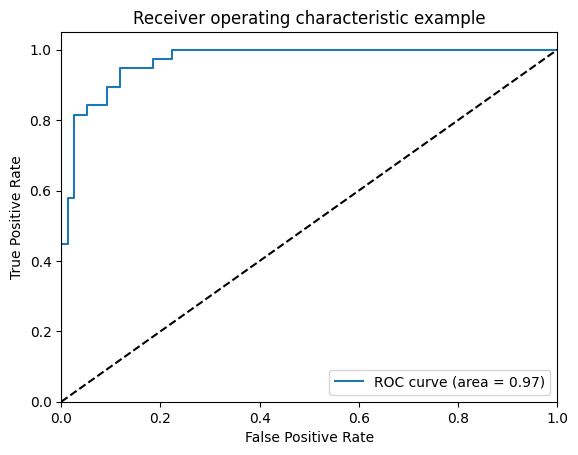

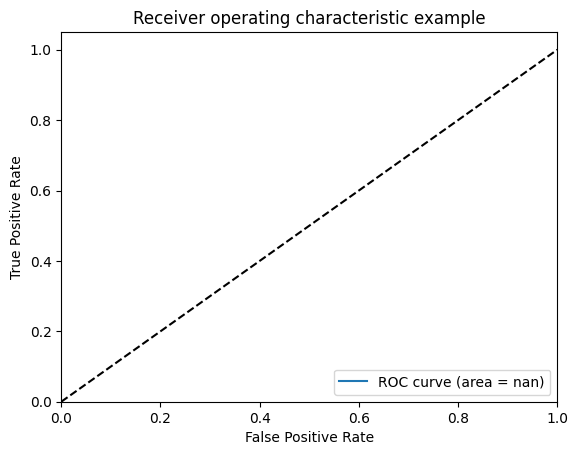

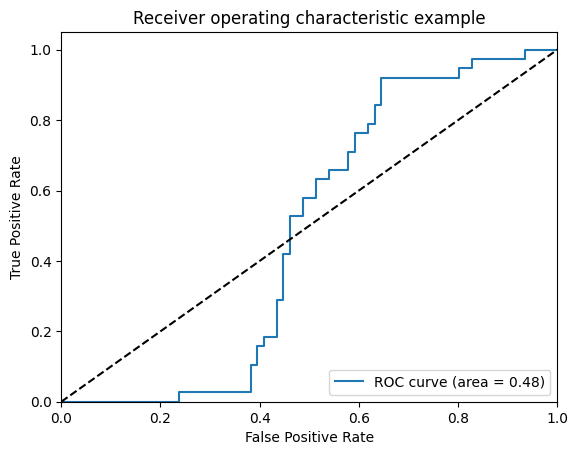

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize the labels
y_bin = label_binarize(y_test_le, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(X_train_tf, y_train_le).predict_proba(X_test_tf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

TODO: Discuss findings

## Step 5

Now I will build and train the BERT model.

In [18]:
MAX_LEN=128
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')



2024-04-26 15:31:58.416885: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-26 15:31:58.416911: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-26 15:31:58.416914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-26 15:31:58.416928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 15:31:58.416939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relatio

4/4 [==============================] - 2s 582ms/step
[0]	train-mlogloss:1.00129	validation-mlogloss:1.04073
[1]	train-mlogloss:0.91560	validation-mlogloss:0.98603
[2]	train-mlogloss:0.83228	validation-mlogloss:0.93665
[3]	train-mlogloss:0.75746	validation-mlogloss:0.89854
[4]	train-mlogloss:0.69432	validation-mlogloss:0.85914
[5]	train-mlogloss:0.63818	validation-mlogloss:0.82533
[6]	train-mlogloss:0.58493	validation-mlogloss:0.79255
[7]	train-mlogloss:0.53593	validation-mlogloss:0.76284
[8]	train-mlogloss:0.49183	validation-mlogloss:0.73554
[9]	train-mlogloss:0.45307	validation-mlogloss:0.71494
[10]	train-mlogloss:0.41770	validation-mlogloss:0.69338
[11]	train-mlogloss:0.38520	validation-mlogloss:0.68031
[12]	train-mlogloss:0.35669	validation-mlogloss:0.66705
[13]	train-mlogloss:0.33002	validation-mlogloss:0.65562
[14]	train-mlogloss:0.30632	validation-mlogloss:0.64760
[15]	train-mlogloss:0.28359	validation-mlogloss:0.64252
[16]	train-mlogloss:0.26402	validation-mlogloss:0.63434
[17]	

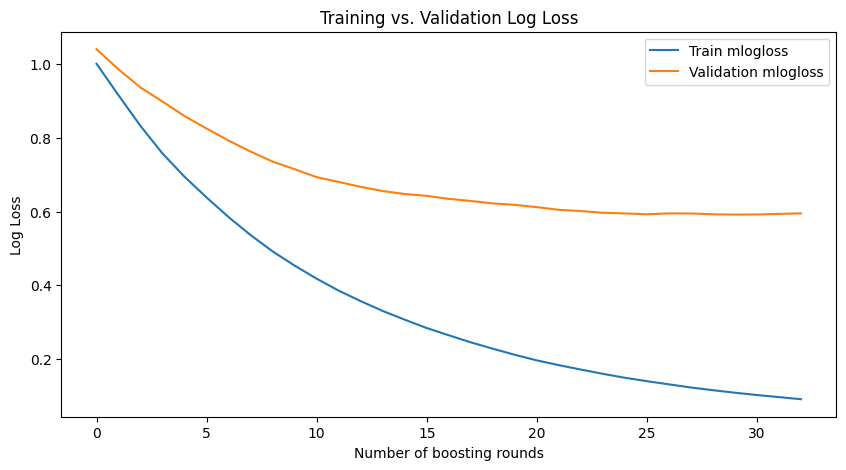

In [35]:
def extract_embeddings(data, model, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    
    # Getting embeddings from the BERT model
    embeddings = model.predict([input_ids, attention_masks])[1]  # Use pooler output (index 1)
    return embeddings

# Extract embeddings
train_embeddings = extract_embeddings(X_train, bert_model, MAX_LEN)
val_embeddings = extract_embeddings(X_valid, bert_model, MAX_LEN)
test_embeddings = extract_embeddings(X_test, bert_model, MAX_LEN)

# Prepare labels (ensure y_train, y_valid are in the correct format for XGBoost)
# Assuming y_train, y_valid are already encoded as one-hot, convert them to single labels
train_labels = np.argmax(y_train.toarray(), axis=1)
val_labels = np.argmax(y_valid.toarray(), axis=1)

# Train XGBoost model
dtrain = xgb.DMatrix(train_embeddings, label=train_labels)
dvalid = xgb.DMatrix(val_embeddings, label=val_labels)
dtest = xgb.DMatrix(test_embeddings)

params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss' 
}

# Train model with early stopping and evals
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain, 'train'), (dvalid, 'validation')],
                early_stopping_rounds=3, evals_result=evals_result)

# Access evaluation results
train_mlogloss = evals_result['train']['mlogloss']
val_mlogloss = evals_result['validation']['mlogloss']

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_mlogloss, label='Train mlogloss')
plt.plot(val_mlogloss, label='Validation mlogloss')
plt.xlabel('Number of boosting rounds')
plt.ylabel('Log Loss')
plt.title('Training vs. Validation Log Loss')
plt.legend()
plt.show()

In [20]:

# Prediction
preds = bst.predict(dtest)

# Evaluate or use predictions as needed

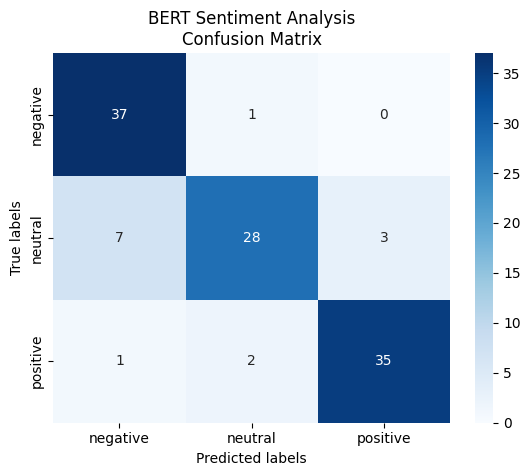

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.82      0.97      0.89        38
     Neutral       0.90      0.74      0.81        38
    Positive       0.92      0.92      0.92        38

    accuracy                           0.88       114
   macro avg       0.88      0.88      0.87       114
weighted avg       0.88      0.88      0.87       114



In [21]:
# Assuming 'y_test' are your true labels and need to be in the correct numerical format
test_labels = np.argmax(y_test.toarray(), axis=1)  # Convert from one-hot if necessary

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('BERT Sentiment Analysis\nConfusion Matrix')
plt.show()

# Classification Report
print('\tClassification Report for BERT:\n\n',classification_report(test_labels, preds, target_names=['Negative', 'Neutral', 'Positive']))